### <b>Part III : OCTMNIST Classification</b>

For this part, we will be working with a real-world dataset - OCTMNIST.</br></br>


The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. Each example is a 28x28 image, associated with a label from 4 classes.</br></br>

Getting the data:</br>
- MedMNIST is a collection of multiple datasets, for this assignment we will be working with one dataset from the collection – OCTMNIST</br>
- pip install medmnist</br>
</br>
References:</br>
- https://medmnist.com/</br>
- https://github.com/MedMNIST/MedMNIST</br>
- Direct download - https://zenodo.org/record/6496656

In [ ]:
# Downloading the dataset

!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=43e1d8bfd0dba6e24db1d07c4a383d1fb09f897b438c5e9e8b2ae50cd2239d59
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


### <b>Steps</b>

1. Download the OCTMNIST 2D dataset and prepare it for training:</br>
a. Preprocess the dataset by normalizing the pixel values to a standardized range, typically between 0 and 1.</br>
b. Split the dataset into three parts: training set, validation set, and test set. The recommended split ratio is 70% for training, 15% for validation, and 15% for testing. Adjust the split ratio based on the size of the dataset and your exploration strategies.

In [ ]:
# Importing necessary libraries
# We will import for of them later - as per requirement

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from medmnist.dataset import OCTMNIST

In [ ]:
# Downloading the OCTMNIST 2D Dataset

octmnist_data = OCTMNIST(root='./', split='train', download=True)

100%|██████████| 54938180/54938180 [00:03<00:00, 15879960.97it/s]


In [ ]:
# Defining normalization transformation

from torchvision import transforms

normalize = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.0], std=[1.0])  # Normalize pixel values to range [0, 1]
])

In [ ]:
# Applying normalization transformation to each component

octmnist_data.transform = normalize

In [ ]:
octmnist_data

Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 97477
    Root location: ./
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets (70:30)
train_data, test_data = train_test_split(octmnist_data, test_size=0.15, random_state=42)

# Further splitting the training set into training and validation sets (70:15:15)
train_data, val_data = train_test_split(train_data, test_size=0.1764769779, random_state=42)

# Storing the components in separate variables
X_train = np.array([np.array(x) for x, _ in train_data])
y_train = np.array([label for _, label in train_data])

X_test = np.array([np.array(x) for x, _ in test_data])
y_test = np.array([label for _, label in test_data])

X_val = np.array([np.array(x) for x, _ in val_data])
y_val = np.array([label for _, label in val_data])

In [ ]:
X_train.shape

(68232, 1, 28, 28)

In [ ]:
y_train.shape

(68232, 1)

In [ ]:
X_val.shape

(14623, 1, 28, 28)

In [ ]:
y_val.shape

(14623, 1)

In [ ]:
X_test.shape

(14622, 1, 28, 28)

In [ ]:
y_test.shape

(14622, 1)

2. Build a neural network:</br>
a. Design a model architecture that consists of at least three layers, including convolutional layers and fully connected layers. You can build an FC NN or CNN model.</br>
b. Ensure appropriate activation functions are applied after each layer to introduce non-linearity.</br>

In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Defining data loaders

batch_size = 64

train_dataset = [(torch.tensor(x).float(), torch.tensor(y).long()) for x, y in zip(X_train, y_train)]
test_dataset = [(torch.tensor(x).float(), torch.tensor(y).long()) for x, y in zip(X_test, y_test)]
val_dataset = [(torch.tensor(x).float(), torch.tensor(y).long()) for x, y in zip(X_val, y_val)]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Defining the CNN (base model) structure / architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Adjusting input size for the fully connected layer
        self.fc2 = nn.Linear(512, 4)  # Output layer with 4 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, (7, 7))  # Adjusting pool size to match the input size of the fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Initializing the model nd putting that into the GPU

model_base = CNN().cuda()

optimizer = optim.Adam(model_base.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

'\nearly_stopping = EarlyStopping(patience=5, verbose=True)\n'

In [ ]:
# Checking if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Training and Validation loop initiated

epochs = 10
train_losses_base = []
val_losses_base = []
train_accuracies_base = []
val_accuracies_base = []

for epoch in range(epochs):
    model_base.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # Training Loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        optimizer.zero_grad()
        outputs = model_base(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = correct_train / total_train
    train_accuracies_base.append(train_accuracy)
    train_loss = running_loss / len(train_loader.dataset)  # Dividing by total dataset size
    train_losses_base.append(train_loss)

    # Validation Loop
    model_base.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
            outputs = model_base(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val
    val_accuracies_base.append(val_accuracy)
    val_loss /= len(val_loader.dataset)  # Dividing by total dataset size
    val_losses_base.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.6951, Train Acc: 0.7455, Val Loss: 0.5193, Val Acc: 0.8219
Epoch [2/10], Train Loss: 0.4723, Train Acc: 0.8336, Val Loss: 0.4359, Val Acc: 0.8444
Epoch [3/10], Train Loss: 0.4138, Train Acc: 0.8525, Val Loss: 0.4188, Val Acc: 0.8504
Epoch [4/10], Train Loss: 0.3846, Train Acc: 0.8633, Val Loss: 0.3767, Val Acc: 0.8671
Epoch [5/10], Train Loss: 0.3558, Train Acc: 0.8734, Val Loss: 0.3694, Val Acc: 0.8703
Epoch [6/10], Train Loss: 0.3355, Train Acc: 0.8810, Val Loss: 0.3820, Val Acc: 0.8636
Epoch [7/10], Train Loss: 0.3117, Train Acc: 0.8885, Val Loss: 0.3591, Val Acc: 0.8727
Epoch [8/10], Train Loss: 0.2891, Train Acc: 0.8973, Val Loss: 0.3501, Val Acc: 0.8805
Epoch [9/10], Train Loss: 0.2712, Train Acc: 0.9054, Val Loss: 0.3282, Val Acc: 0.8872
Epoch [10/10], Train Loss: 0.2519, Train Acc: 0.9106, Val Loss: 0.3305, Val Acc: 0.8900


In [ ]:
# Testing the model

model_base.eval()
test_loss_base = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        outputs = model_base(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        test_loss_base += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy_base = correct_test / total_test
test_loss_base /= len(test_loader.dataset)  # Dividing by total dataset size

print(f'Test Loss: {test_loss_base:.4f}, Test Acc: {test_accuracy_base:.4f}')

Test Loss: 0.3100, Test Acc: 0.8951


In [ ]:
# Saving the base model

torch.save(model_base.state_dict(), 'base_model.pth')

3. Apply following techniques to prevent overfitting and discuss each of them and how they impact the performance:</br>
a. Regularization: Apply regularization techniques, such as L1 or L2 regularization, to the model's parameters.</br>
b. Dropout: Introduce dropout layers between the fully connected layers.</br>
c. Early stopping: Monitor the performance of the model on a validation set and stop training when the validation loss stops improving.</br>
d. Expected min accuracy: 70%

In [ ]:
# MODEL - 1 : Now we will add Regularization

model_1 = CNN().cuda()

# Regularization :
# Applying L2 regularization (weight decay) to the model's parameters
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# MODEL - 1 : Training

epochs = 10
train_losses_1 = []
val_losses_1 = []
train_accuracies_1 = []
val_accuracies_1 = []

for epoch in range(epochs):
    model_1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        optimizer_1.zero_grad()
        outputs = model_1(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = correct_train / total_train
    train_accuracies_1.append(train_accuracy)
    train_loss = running_loss / len(train_loader.dataset)  # Dividing by total dataset size
    train_losses_1.append(train_loss)

    model_1.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
            outputs = model_1(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val
    val_accuracies_1.append(val_accuracy)
    val_loss /= len(val_loader.dataset)  # Dividing by total dataset size
    val_losses_1.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.7722, Train Acc: 0.7122, Val Loss: 0.5891, Val Acc: 0.7944
Epoch [2/10], Train Loss: 0.5314, Train Acc: 0.8129, Val Loss: 0.5155, Val Acc: 0.8211
Epoch [3/10], Train Loss: 0.4728, Train Acc: 0.8328, Val Loss: 0.4393, Val Acc: 0.8437
Epoch [4/10], Train Loss: 0.4435, Train Acc: 0.8426, Val Loss: 0.4626, Val Acc: 0.8338
Epoch [5/10], Train Loss: 0.4229, Train Acc: 0.8495, Val Loss: 0.4601, Val Acc: 0.8411
Epoch [6/10], Train Loss: 0.4097, Train Acc: 0.8546, Val Loss: 0.4038, Val Acc: 0.8561
Epoch [7/10], Train Loss: 0.3975, Train Acc: 0.8592, Val Loss: 0.4005, Val Acc: 0.8576
Epoch [8/10], Train Loss: 0.3922, Train Acc: 0.8612, Val Loss: 0.3905, Val Acc: 0.8601
Epoch [9/10], Train Loss: 0.3825, Train Acc: 0.8652, Val Loss: 0.3906, Val Acc: 0.8624
Epoch [10/10], Train Loss: 0.3757, Train Acc: 0.8671, Val Loss: 0.3853, Val Acc: 0.8640


In [ ]:
# MODEL - 1 : Testing the model

model_1.eval()
test_loss_1 = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        outputs = model_1(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        test_loss_base += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy_1 = correct_test / total_test
test_loss_1 /= len(test_loader.dataset)  # Dividing by total dataset size

print(f'Test Loss: {test_loss_1:.4f}, Test Acc: {test_accuracy_1:.4f}')

Test Loss: 0.0000, Test Acc: 0.8696


In [ ]:
# Saving the MODEL - 1

torch.save(model_1.state_dict(), 'model_1_regularization.pth')

In [ ]:
# MODEL - 2 : Adding Dropout into the Fully connected layers

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, (7, 7))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applying dropout before the fully connected layer
        x = self.fc2(x)
        return x


In [ ]:
model_2 = CNN2().cuda()
optimizer_1 = optim.Adam(model_2.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# MODEL - 2 : Training the model

epochs = 10
train_losses_2 = []
val_losses_2 = []
train_accuracies_2 = []
val_accuracies_2 = []

for epoch in range(epochs):
    model_2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        optimizer_1.zero_grad()
        outputs = model_2(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = correct_train / total_train
    train_accuracies_2.append(train_accuracy)
    train_loss = running_loss / len(train_loader.dataset)  # Dividing by total dataset size
    train_losses_2.append(train_loss)

    model_2.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
            outputs = model_2(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val
    val_accuracies_2.append(val_accuracy)
    val_loss /= len(val_loader.dataset)  # Dividing by total dataset size
    val_losses_2.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.7481, Train Acc: 0.7273, Val Loss: 0.5733, Val Acc: 0.7981
Epoch [2/10], Train Loss: 0.5548, Train Acc: 0.8062, Val Loss: 0.5032, Val Acc: 0.8232
Epoch [3/10], Train Loss: 0.5119, Train Acc: 0.8206, Val Loss: 0.4839, Val Acc: 0.8314
Epoch [4/10], Train Loss: 0.4796, Train Acc: 0.8307, Val Loss: 0.4623, Val Acc: 0.8401
Epoch [5/10], Train Loss: 0.4552, Train Acc: 0.8388, Val Loss: 0.4266, Val Acc: 0.8470
Epoch [6/10], Train Loss: 0.4417, Train Acc: 0.8449, Val Loss: 0.4169, Val Acc: 0.8518
Epoch [7/10], Train Loss: 0.4291, Train Acc: 0.8480, Val Loss: 0.4013, Val Acc: 0.8551
Epoch [8/10], Train Loss: 0.4203, Train Acc: 0.8511, Val Loss: 0.4794, Val Acc: 0.8292
Epoch [9/10], Train Loss: 0.4100, Train Acc: 0.8554, Val Loss: 0.4040, Val Acc: 0.8569
Epoch [10/10], Train Loss: 0.4014, Train Acc: 0.8588, Val Loss: 0.4141, Val Acc: 0.8511


In [ ]:
# MODEL - 2 : Testing the model

model_2.eval()
test_loss_2 = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        outputs = model_2(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        test_loss_base += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy_2 = correct_test / total_test
test_loss_2 /= len(test_loader.dataset)  # Dividing by total dataset size

print(f'Test Loss: {test_loss_2:.4f}, Test Acc: {test_accuracy_2:.4f}')

Test Loss: 0.0000, Test Acc: 0.8556


In [ ]:
# Saving the MODEL - 2

torch.save(model_2.state_dict(), 'model_2_reg_dropout.pth')

In [ ]:
# MODEL - 3 : Adding Early Stopping

model_3 = CNN2().cuda()
optimizer_1 = optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10
train_losses_3 = []
val_losses_3 = []
train_accuracies_3 = []
val_accuracies_3 = []

patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(epochs):
    model_3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        optimizer_1.zero_grad()
        outputs = model_3(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_accuracy = correct_train / total_train
    train_accuracies_3.append(train_accuracy)
    train_loss = running_loss / len(train_loader.dataset)  # Dividing by total dataset size
    train_losses_3.append(train_loss)

    model_3.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
            outputs = model_3(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)  # Multiplying by batch size of labels
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val
    val_accuracies_3.append(val_accuracy)
    val_loss /= len(val_loader.dataset)  # Dividing by total dataset size
    val_losses_3.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. No improvement in validation loss for {} consecutive epochs.".format(patience))
        break

Epoch [1/10], Train Loss: 0.7452, Train Acc: 0.7268, Val Loss: 0.6326, Val Acc: 0.7769
Epoch [2/10], Train Loss: 0.5484, Train Acc: 0.8092, Val Loss: 0.4845, Val Acc: 0.8280
Epoch [3/10], Train Loss: 0.4988, Train Acc: 0.8264, Val Loss: 0.4846, Val Acc: 0.8279
Epoch [4/10], Train Loss: 0.4635, Train Acc: 0.8373, Val Loss: 0.5237, Val Acc: 0.8182
Epoch [5/10], Train Loss: 0.4480, Train Acc: 0.8435, Val Loss: 0.4282, Val Acc: 0.8481
Epoch [6/10], Train Loss: 0.4299, Train Acc: 0.8497, Val Loss: 0.4455, Val Acc: 0.8480
Epoch [7/10], Train Loss: 0.4201, Train Acc: 0.8518, Val Loss: 0.4036, Val Acc: 0.8578
Epoch [8/10], Train Loss: 0.4122, Train Acc: 0.8543, Val Loss: 0.4198, Val Acc: 0.8471
Epoch [9/10], Train Loss: 0.4013, Train Acc: 0.8585, Val Loss: 0.3843, Val Acc: 0.8676
Epoch [10/10], Train Loss: 0.3953, Train Acc: 0.8600, Val Loss: 0.3773, Val Acc: 0.8651


In [ ]:
# MODEL - 3 : Tesing the model

model_3.eval()
test_loss_3 = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving batch to GPU
        outputs = model_3(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        test_loss_base += loss.item() * labels.size(0)  # Multiplying by batch size of labels
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy_3 = correct_test / total_test
test_loss_3 /= len(test_loader.dataset)  # Dividing by total dataset size

print(f'Test Loss: {test_loss_3:.4f}, Test Acc: {test_accuracy_3:.4f}')

Test Loss: 0.0000, Test Acc: 0.8711


In [ ]:
# Saving the MODEL - 3

torch.save(model_3.state_dict(), 'model_3_reg_dropout_early_stopping.pth')

5. Discuss the results and provide relevant graphs:</br>
a. Report training accuracy, training loss, validation accuracy, validation loss,
testing accuracy, and testing loss.</br>
b. Plot the training and validation accuracy over time (epochs).</br>
c. Plot the training and validation loss over time (epochs).</br>
d. Generate a confusion matrix using the model's predictions on the test set.</br>
e. Calculate and report other evaluation metrics such as precision, recall (scikitlearn),
and F1 score (scikit-learn) to further analyze the model's performance on
the test set.

In [ ]:
'''
a. Report training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss.
'''

print("BASE MODEL\n")
print("Training Accuracies : ", train_accuracies_base,"\n")
print("Training Losses : ", train_losses_base,"\n")
print("Validation Accuracies : ", val_accuracies_base,"\n")
print("Validation Losses : ", val_losses_base,"\n")
print("Testing Accuracy : ", test_accuracy_base,"\n")
print("Testing Loss : ", test_loss_base,"\n")

print("MODEL - 1\n")
print("Training Accuracies : ", train_accuracies_1,"\n")
print("Training Losses : ", train_losses_1,"\n")
print("Validation Accuracies : ", val_accuracies_1,"\n")
print("Validation Losses : ", val_losses_1,"\n")
print("Testing Accuracy : ", test_accuracy_1,"\n")
print("Testing Loss : ", test_loss_1,"\n")

print("MODEL - 2\n")
print("Training Accuracies : ", train_accuracies_2,"\n")
print("Training Losses : ", train_losses_2,"\n")
print("Validation Accuracies : ", val_accuracies_2,"\n")
print("Validation Losses : ", val_losses_2,"\n")
print("Testing Accuracy : ", test_accuracy_2,"\n")
print("Testing Loss : ", test_loss_2,"\n")

print("MODEL - 3\n")
print("Training Accuracies : ", train_accuracies_3,"\n")
print("Training Losses : ", train_losses_3,"\n")
print("Validation Accuracies : ", val_accuracies_3,"\n")
print("Validation Losses : ", val_losses_3,"\n")
print("Testing Accuracy : ", test_accuracy_3,"\n")
print("Testing Loss : ", test_loss_3,"\n")


BASE MODEL

Training Accuracies :  [0.7455446124985344, 0.8335678274123578, 0.8524885684136475, 0.8633046078086528, 0.8734025090866455, 0.8809649431351858, 0.888483409543909, 0.8973355610270841, 0.9054256067534294, 0.9105991323719076] 

Training Losses :  [0.6950881441965348, 0.4723005994625004, 0.4138292505951053, 0.38460023432659063, 0.355773980765207, 0.3354778113825294, 0.3116881008066568, 0.2890585736392433, 0.2712034786159149, 0.251932991992017] 

Validation Accuracies :  [0.821855980304999, 0.8444231689803734, 0.8503727005402448, 0.8670587430759762, 0.8702728578267114, 0.8636394720645558, 0.872734732954934, 0.880462285440744, 0.8872324420433564, 0.8900362442727211] 

Validation Losses :  [0.5192934620285021, 0.43586099859074107, 0.4188299968472863, 0.3766964159308254, 0.36944431856866655, 0.3820317662594575, 0.3591384466513069, 0.3500616333842204, 0.3281893187738073, 0.3305215126026152] 

Testing Accuracy :  0.8950895910272193 

Testing Loss :  16689.30605043296 

MODEL - 1

Tra

In [ ]:
# So we can clearly conclude that the base model gave the best performace

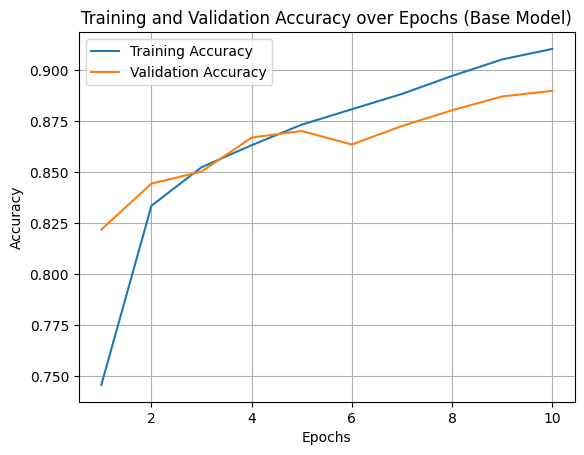

In [ ]:
'''
b. Plot the training and validation accuracy over time (epochs).
'''

# BASE MODEL

plt.plot(range(1, len(train_accuracies_base) + 1), train_accuracies_base, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies_base) + 1), val_accuracies_base, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Base Model)')
plt.legend()
plt.grid(True)
plt.show()

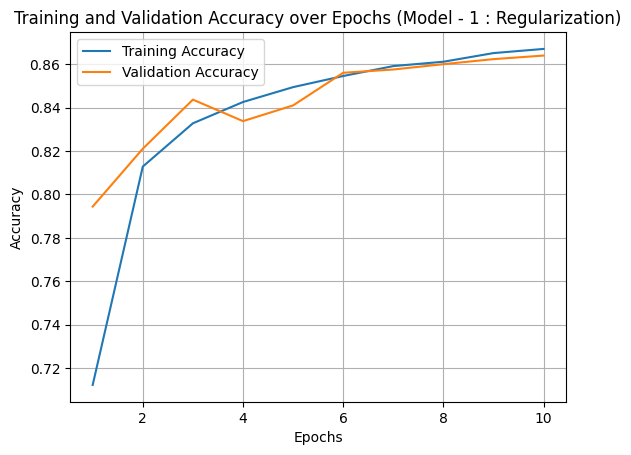

In [ ]:
# MODEL - 1

plt.plot(range(1, len(train_accuracies_1) + 1), train_accuracies_1, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies_1) + 1), val_accuracies_1, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Model - 1 : Regularization)')
plt.legend()
plt.grid(True)
plt.show()

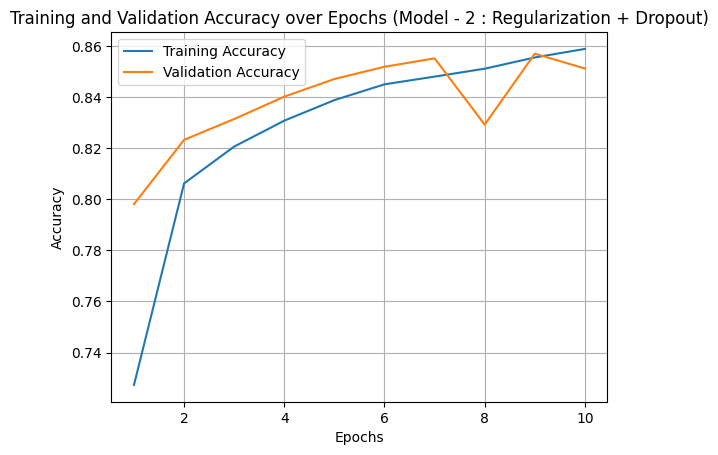

In [ ]:
# MODEL - 2

plt.plot(range(1, len(train_accuracies_2) + 1), train_accuracies_2, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies_2) + 1), val_accuracies_2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Model - 2 : Regularization + Dropout)')
plt.legend()
plt.grid(True)
plt.show()

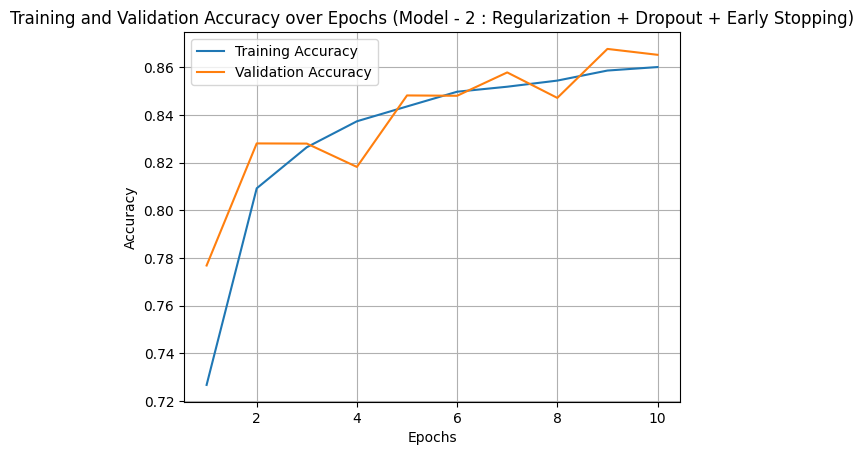

In [ ]:
# MODEL - 3

plt.plot(range(1, len(train_accuracies_3) + 1), train_accuracies_3, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies_3) + 1), val_accuracies_3, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (Model - 2 : Regularization + Dropout + Early Stopping)')
plt.legend()
plt.grid(True)
plt.show()

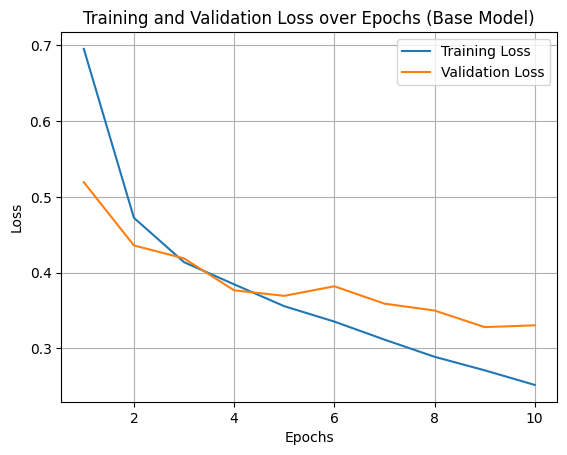

In [ ]:
'''
c. Plot the training and validation loss over time (epochs).
'''

# Base Model

plt.plot(range(1, len(train_losses_base) + 1), train_losses_base, label='Training Loss')
plt.plot(range(1, len(val_losses_base) + 1), val_losses_base, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Base Model)')
plt.legend()
plt.grid(True)
plt.show()

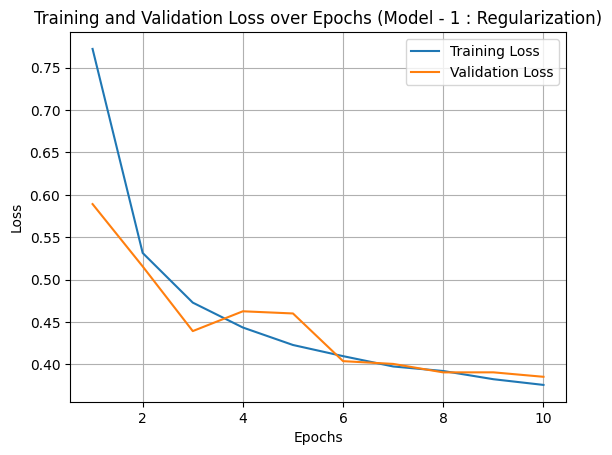

In [ ]:
# MODEL - 1

plt.plot(range(1, len(train_losses_1) + 1), train_losses_1, label='Training Loss')
plt.plot(range(1, len(val_losses_1) + 1), val_losses_1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Model - 1 : Regularization)')
plt.legend()
plt.grid(True)
plt.show()

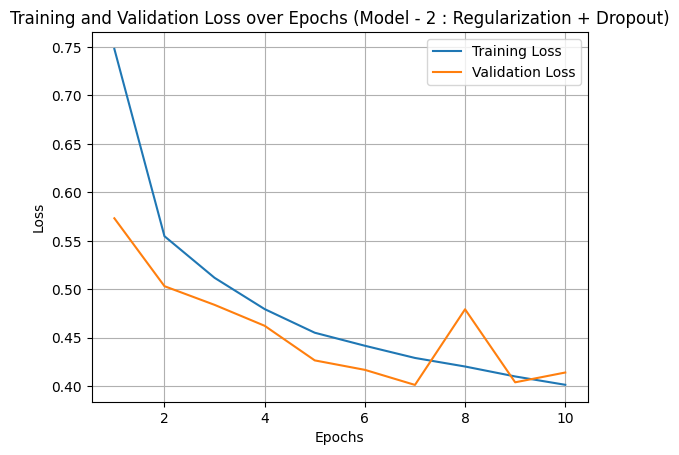

In [ ]:
# MODEL - 2

plt.plot(range(1, len(train_losses_2) + 1), train_losses_2, label='Training Loss')
plt.plot(range(1, len(val_losses_2) + 1), val_losses_2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Model - 2 : Regularization + Dropout)')
plt.legend()
plt.grid(True)
plt.show()

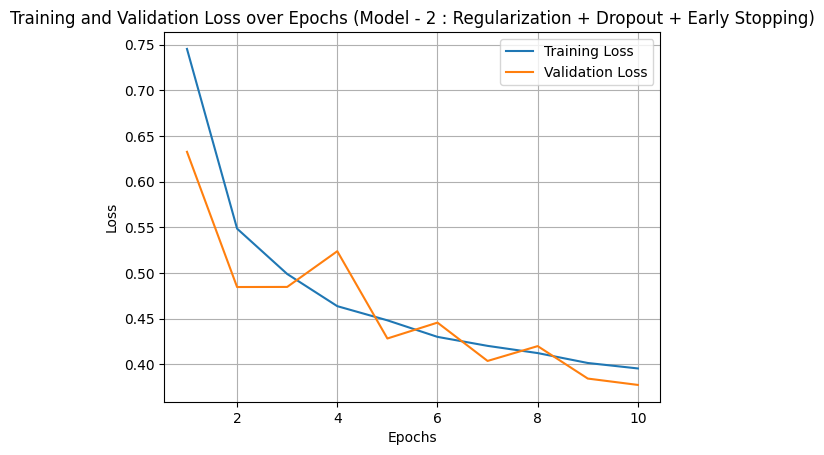

In [ ]:
# MODEL - 3

plt.plot(range(1, len(train_losses_3) + 1), train_losses_3, label='Training Loss')
plt.plot(range(1, len(val_losses_3) + 1), val_losses_3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Model - 2 : Regularization + Dropout + Early Stopping)')
plt.legend()
plt.grid(True)
plt.show()

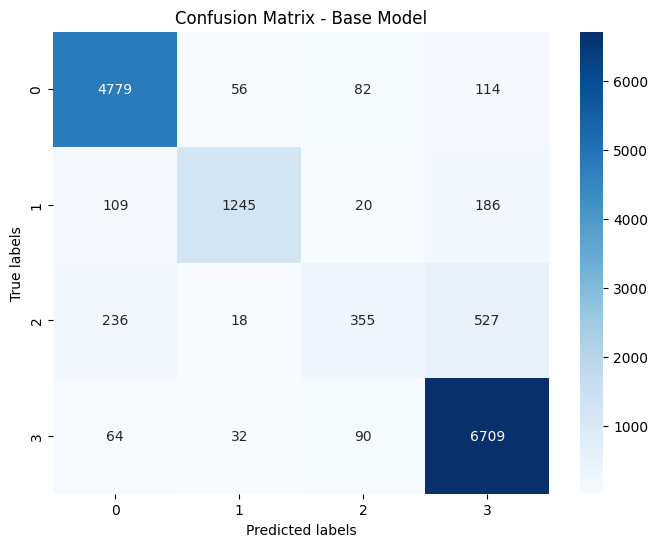

In [ ]:
'''
d. Generate a confusion matrix using the model's predictions on the test set.
'''

# Base Model

model_base.eval()
predictions_base = []
true_labels_base = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_base(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_base.extend(predicted.cpu().numpy())
        true_labels_base.extend(labels.cpu().numpy())

# Computing confusion matrix
conf_matrix = confusion_matrix(true_labels_base, predictions_base)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Base Model')
plt.show()

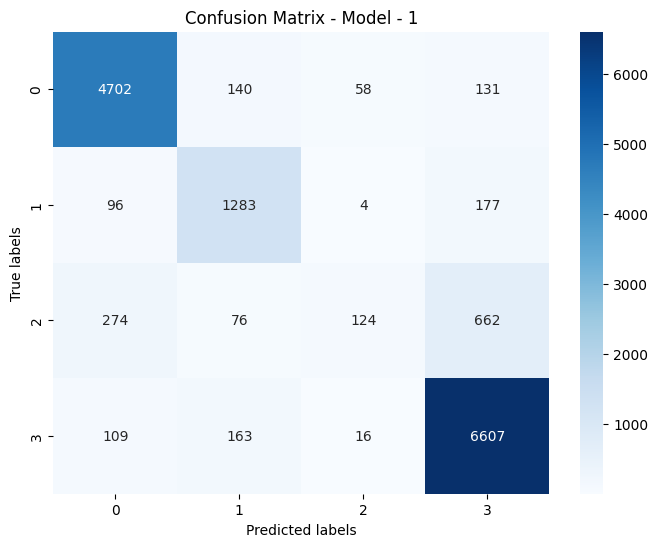

In [ ]:
# Model - 1

model_1.eval()
predictions_1 = []
true_labels_1 = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_1(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_1.extend(predicted.cpu().numpy())
        true_labels_1.extend(labels.cpu().numpy())

# Computing confusion matrix
conf_matrix = confusion_matrix(true_labels_1, predictions_1)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Model - 1')
plt.show()

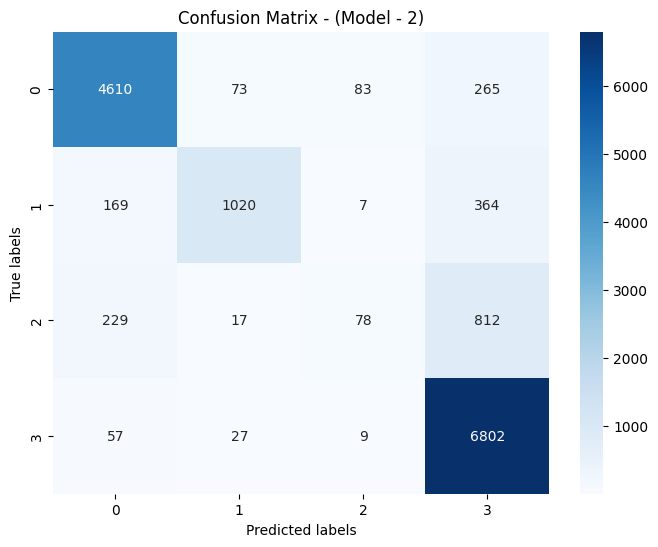

In [ ]:
# Model - 2

model_2.eval()
predictions_2 = []
true_labels_2 = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_2(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_2.extend(predicted.cpu().numpy())
        true_labels_2.extend(labels.cpu().numpy())

# Computing confusion matrix
conf_matrix = confusion_matrix(true_labels_2, predictions_2)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - (Model - 2)')
plt.show()

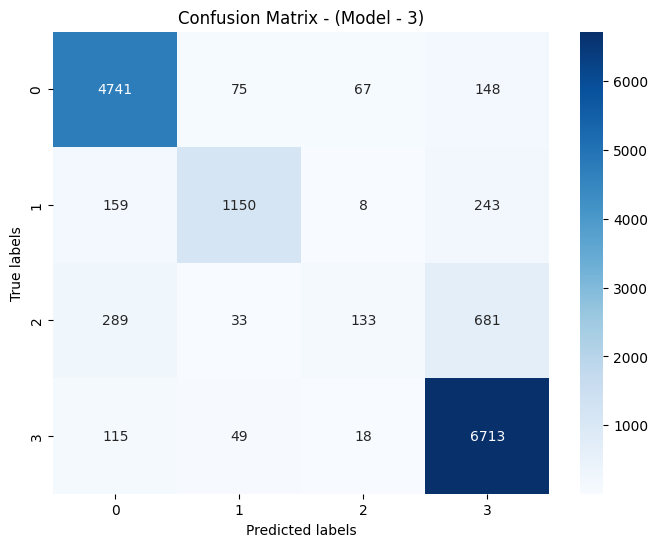

In [ ]:
# Model - 3

model_3.eval()
predictions_3 = []
true_labels_3 = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_3(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions_3.extend(predicted.cpu().numpy())
        true_labels_3.extend(labels.cpu().numpy())

# Computing confusion matrix
conf_matrix = confusion_matrix(true_labels_3, predictions_3)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - (Model - 3)')
plt.show()

In [ ]:
'''
e. Calculate and report other evaluation metrics such as precision, recall (scikitlearn),
and F1 score (scikit-learn) to further analyze the model's performance on
the test set.
'''

# Base Model

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels_base, predictions_base)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      5031
           1       0.92      0.80      0.86      1560
           2       0.65      0.31      0.42      1136
           3       0.89      0.97      0.93      6895

    accuracy                           0.90     14622
   macro avg       0.85      0.76      0.79     14622
weighted avg       0.89      0.90      0.88     14622



In [ ]:
# Model - 1

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels_1, predictions_1)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      5031
           1       0.77      0.82      0.80      1560
           2       0.61      0.11      0.19      1136
           3       0.87      0.96      0.91      6895

    accuracy                           0.87     14622
   macro avg       0.79      0.71      0.70     14622
weighted avg       0.85      0.87      0.85     14622



In [ ]:
# Model - 2

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels_2, predictions_2)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      5031
           1       0.90      0.65      0.76      1560
           2       0.44      0.07      0.12      1136
           3       0.83      0.99      0.90      6895

    accuracy                           0.86     14622
   macro avg       0.77      0.66      0.67     14622
weighted avg       0.83      0.86      0.83     14622



In [ ]:
# Model - 3

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels_3, predictions_3)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      5031
           1       0.88      0.74      0.80      1560
           2       0.59      0.12      0.20      1136
           3       0.86      0.97      0.91      6895

    accuracy                           0.87     14622
   macro avg       0.81      0.69      0.71     14622
weighted avg       0.85      0.87      0.85     14622

